In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, DateTime

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Msmt = Base.classes.measurement
Stn = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
inspector = inspect(engine)
# Get a list of column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Get a list of column names and types
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
recent_date = session.query(Msmt.date).order_by(Msmt.date.desc()).first()
recent_date

('2017-08-23',)

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date2 = pd.to_datetime(recent_date[0])
yy = recent_date2.year
mm = recent_date2.month
dd = recent_date2.day
# Calculate the date one year from the last date in data set.
query_date = dt.date(yy, mm, dd) - dt.timedelta(days=365)
print("Query Date: ", query_date)

Query Date:  2016-08-23


In [13]:
# Perform a query to retrieve the data and precipitation scores
prcp_qry=session.query(Msmt.date, Msmt.prcp).\
    filter(Msmt.date >= query_date).all()

In [14]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(prcp_qry)
prcp_df

,date,prcp
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00
...,...,...
2225,2017-08-19,0.09
2226,2017-08-20,NaN
2227,2017-08-21,0.56
2228,2017-08-22,0.50


In [15]:
# Sort the dataframe by date
prcp_df2 = prcp_df.sort_values(by='date')
prcp_df2


,date,prcp
0,2016-08-23,0.00
1009,2016-08-23,NaN
1529,2016-08-23,1.79
704,2016-08-23,0.05
361,2016-08-23,0.15
...,...,...
1527,2017-08-22,0.00
1008,2017-08-23,0.00
360,2017-08-23,0.00
1528,2017-08-23,0.08


In [16]:
## Remove null values
prcp_df2 = prcp_df2.dropna()
prcp_df2

,date,prcp
0,2016-08-23,0.00
1529,2016-08-23,1.79
704,2016-08-23,0.05
361,2016-08-23,0.15
1881,2016-08-23,0.70
...,...,...
1527,2017-08-22,0.00
1008,2017-08-23,0.00
360,2017-08-23,0.00
1528,2017-08-23,0.08


In [17]:
## Confirm no null values
prcp_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2021 entries, 0 to 2229
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    2021 non-null   object 
 1   prcp    2021 non-null   float64
dtypes: float64(1), object(1)
memory usage: 47.4+ KB


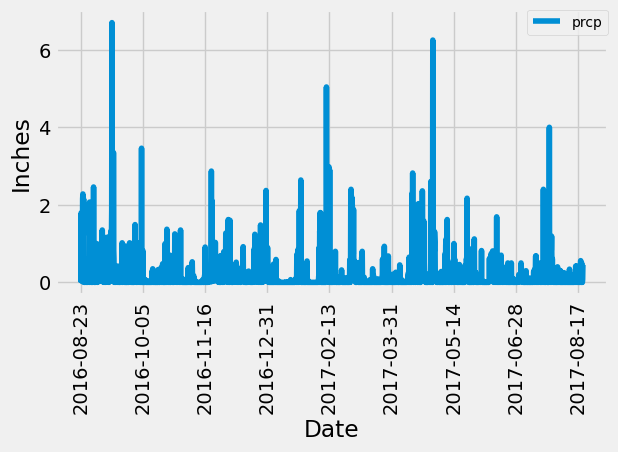

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df2.index = prcp_df2['date']
fig, ax = plt.subplots()
ax = prcp_df2.plot(ax=ax)
ax.legend(fontsize=10, loc="best", borderaxespad=0)
plt.xticks(rotation="vertical")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.tight_layout()

In [19]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df2.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [20]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Stn.station)).all()
total_stations

[(9,)]

In [21]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
sel = [Msmt.station, func.count(Msmt.date)]
totals = session.query(*sel).\
        group_by(Msmt.station).\
        order_by(func.count(Msmt.date).desc()).all()
totals

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.min(Msmt.tobs),
       func.max(Msmt.tobs),
       func.avg(Msmt.tobs)]
active_station = session.query(*sel).\
    filter(Msmt.station == totals[0][0]).all()
  
active_station

[(54.0, 85.0, 71.66378066378067)]

In [23]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
stn_date1 = session.query(Msmt.date).\
    filter(Msmt.station == totals[0][0]).\
    order_by(Msmt.date.desc()).first()
stn_date1_str = stn_date1[0]
stn_date1_str

'2017-08-18'

In [24]:
stn_date2 = pd.to_datetime(stn_date1[0])
yys = stn_date2.year
mms = stn_date2.month
dds = stn_date2.day
# Calculate the date one year from the last date in data set.
query_date2 = dt.date(yys, mms, dds) - dt.timedelta(days=365)
print("Query Date: ", query_date2)

Query Date:  2016-08-18


In [25]:
tobs_qry = session.query(Msmt.date, Msmt.tobs).\
    filter(Msmt.station == totals[0][0]).\
    filter(Msmt.date >= query_date2).all()

In [26]:
tobs_df = pd.DataFrame(tobs_qry).dropna()
tobs_df

,date,tobs
0,2016-08-18,80.0
1,2016-08-19,79.0
2,2016-08-20,81.0
3,2016-08-21,79.0
4,2016-08-22,78.0
...,...,...
352,2017-08-14,77.0
353,2017-08-15,77.0
354,2017-08-16,76.0
355,2017-08-17,76.0


Text(0.5, 0, 'Temperature')

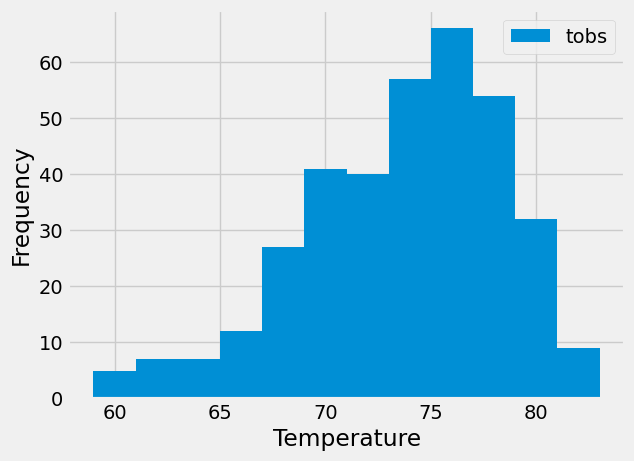

In [27]:
tobs_df.plot(kind='hist', bins=12)
plt.xlabel('Temperature')

# Close Session

In [28]:
# Close Session
session.close()